# IMPORTS

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

## Data

Check len of processed dataframes

In [2]:
from novelty_detection.data import load_data, save_img
from novelty_detection.preprocessing import *

count=0

while True:
    try:
        name = f"gaia_data_{count}.csv"
        df = load_data(name, header_names=None)
        df_date = convert_df_time_column_to_datetime(df)
        df_index = convert_df_to_df_with_datetime_index(df_date)
        idx=df_index.index
        print(name, ', num rows:' ,len(df),', days:', (idx[-1]-idx[0]).days)
    except ValueError:
        break
    count+=1

gaia_data_0.csv , num rows: 2520 , days: 3
gaia_data_1.csv , num rows: 15862 , days: 22
gaia_data_2.csv , num rows: 6991 , days: 9
gaia_data_3.csv , num rows: 2879 , days: 3
gaia_data_4.csv , num rows: 4259 , days: 5
gaia_data_5.csv , num rows: 3576 , days: 4
gaia_data_6.csv , num rows: 2106 , days: 2
gaia_data_7.csv , num rows: 1011 , days: 1
gaia_data_8.csv , num rows: 1643 , days: 2
gaia_data_9.csv , num rows: 4157 , days: 5
gaia_data_10.csv , num rows: 1486 , days: 2


In [3]:
data_to_load = "gaia_data_1.csv"

df = load_data(data_to_load, header_names=None)
df_date = convert_df_time_column_to_datetime(df)
df_index = convert_df_to_df_with_datetime_index(df_date)
print(df_index.shape)
df_index.head()

(15862, 12)


,T_ext,Solar_irrad,T_imp,BC1_power,BC2_power,Refr1_power,Refr2_power,BC1_flow,BC2_flow,Refr1_flow,Refr2_flow,T_ret
datetime,,,,,,,,,,,,
2022-05-18 00:02:00+00:00,19.450001,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:04:00+00:00,19.450001,0.0,15.070007,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.320007
2022-05-18 00:06:00+00:00,19.450001,0.0,14.980011,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:08:00+00:00,19.510000,0.0,15.040009,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.260010
2022-05-18 00:10:00+00:00,19.510000,0.0,15.110001,0.2,0.3,0.3,0.3,0.0,0.0,0.0,0.0,15.275009


# TIMESERIES PLOTS

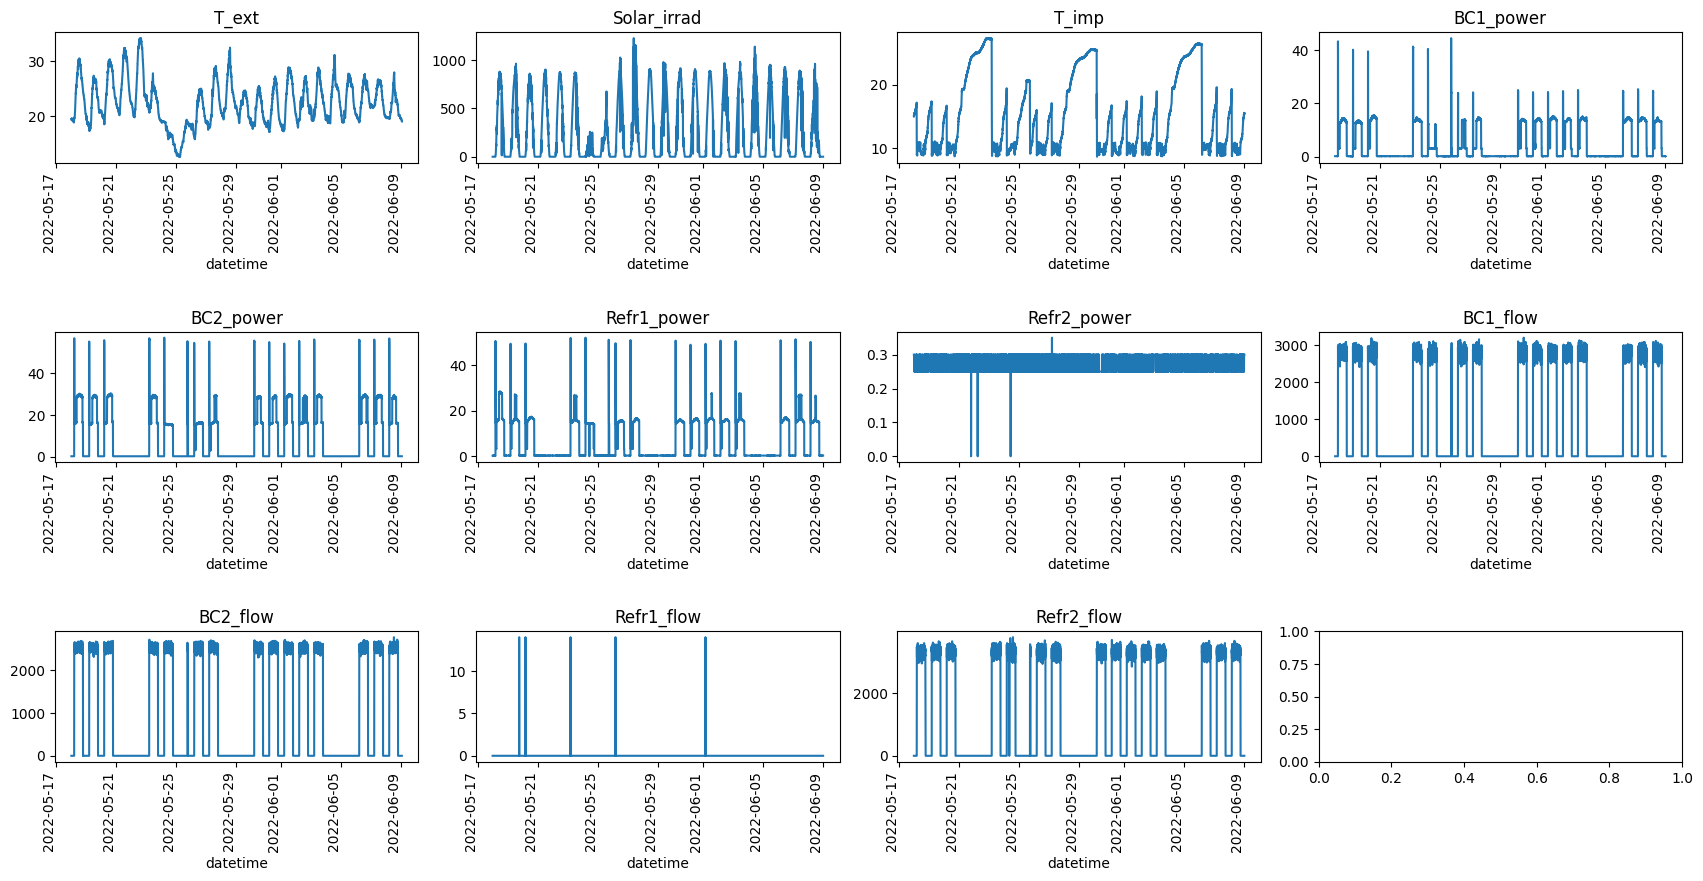

In [4]:
columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow']

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(17, 10))
fig.tight_layout(rect=[0, 0.70, 1, 0.95])
axes = axes.flatten()
for i,col in enumerate(columns):
    df_index[[col]].plot(ax=axes[i], legend=False, title=col, x_compat=True, rot=90,)

# CORRELATION PLOT

The last column of the correlation matrix corresponds to the corralations between T_ret and the other variables

In [5]:
correaltions = df_index.corr(method='pearson').iloc[:-1,-1]
d_correlations = correaltions.to_dict()
d_correlations

{'T_ext': 0.07344646521395903,
 'Solar_irrad': -0.1114587729121601,
 'T_imp': 0.9956685214769546,
 'BC1_power': -0.5224151423771946,
 'BC2_power': -0.5734907388956445,
 'Refr1_power': -0.5807952171763714,
 'Refr2_power': 0.2787085975516951,
 'BC1_flow': -0.6589099011434657,
 'BC2_flow': -0.6594183856572436,
 'Refr1_flow': 0.007168048012684047,
 'Refr2_flow': -0.6615336110924506}

In [6]:
columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow']

list_of_dict = []

for shift in range(2000):
    df_copy=df_index.copy()
    df_copy[columns] = df_copy[columns].shift(shift)
    df_remove = df_copy.iloc[shift:]
    correaltions = df_remove.corr(method='pearson').iloc[:,-1] 
    d_correlations = correaltions.to_dict()
    list_of_dict.append(d_correlations)

df_corr = pd.DataFrame(list_of_dict, columns=list(list_of_dict[0].keys()))

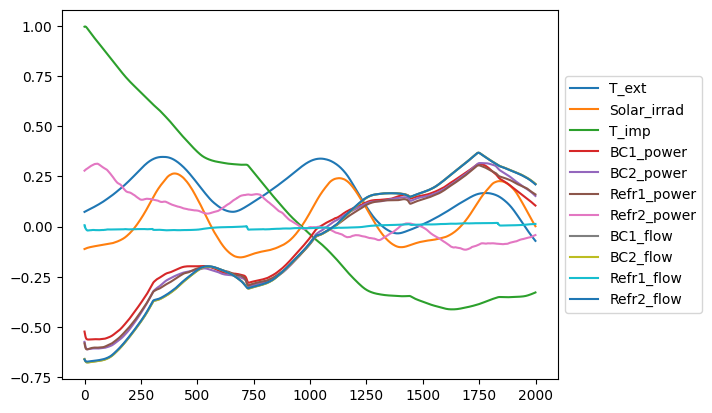

In [7]:
fig, ax = plt.subplots()
df_corr[columns].plot(ax=ax)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# FREQUENCY PLOT

The FFT of a real-valued input signal (like all our dataset columns) will produce negative frequencies that are just mirrored duplicates of the positive frequencies, and can thus be ignored when analyzing the result. To ignore them, we only have to ignore the seconf half of the data.

(0.0, 4e-05)

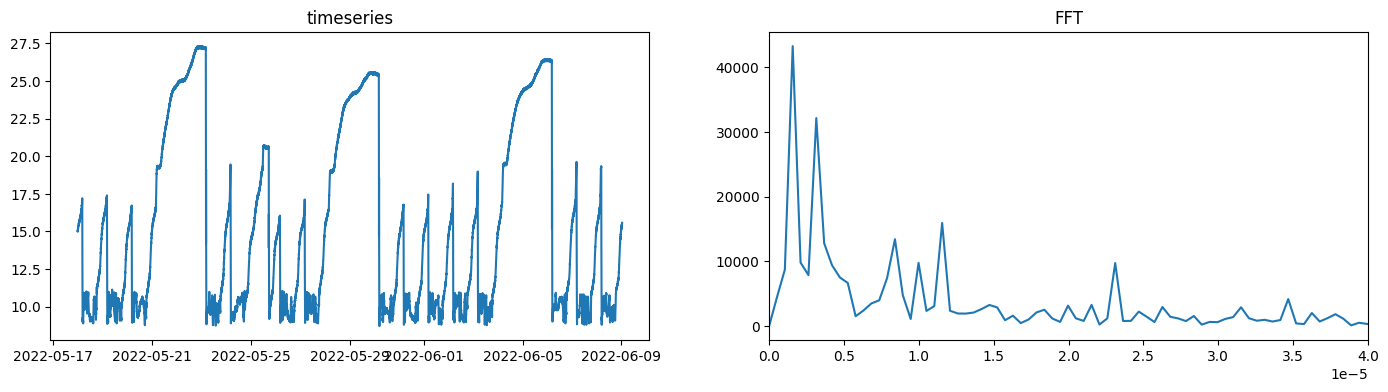

In [8]:
varaible='T_imp'

var_fft = np.fft.fft(df_index[varaible])
var_fft[0] = 0
var_mag = np.abs(var_fft)
frate = 1/120 # seconds
n = len(var_fft)
freqs = np.fft.fftfreq(n, 1./frate) # cycles/second

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
axes[0].plot(df_index.index, df_index[varaible])
axes[0].title.set_text('timeseries')
axes[1].plot(freqs[:n//2], var_mag[:n//2])
axes[1].title.set_text('FFT')

axes[1].set_xlim([0, 0.00004])

# Save plots to images

In [10]:
x_columns = ['T_ext', 'Solar_irrad', 'T_imp', 
           'BC1_power', 'BC2_power', 'Refr1_power', 
           'Refr2_power', 'BC1_flow', 'BC2_flow', 
           'Refr1_flow', 'Refr2_flow']

all_columns = x_columns + ['T_ret']

plt1 = timeseries_plot(df_index, all_columns, (3,4), plot_size=(500,800), margin=300, spacing =435, dpi=200.)
plt2 = correlation_plot(df_index, x_columns, max_shift=2000, plot_size=(600,1000), margin=300, spacing =435, dpi=200.)
plt3 = frequency_plot(df_index, all_columns, (3,4), frate=1/120, max_freq=0.00004, plot_size=(500,800), margin=150, spacing =300, dpi=200.)

save_img(plt1, 'timeseries_plot.png', data_type='plots')
save_img(plt2, 'correlation_plot.png', data_type='plots')
save_img(plt3, 'frequency_plot.png', data_type='plots')